## 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD

import xgboost as xgb

from tqdm.notebook import tqdm

## 1. Set Up Constants

In [2]:
RSI_ROLLING_WINDOW_SIZE = 14

TEST_SIZE = 0.2
SEQUENCE_LENGTH = 14
RANDOM_STATE_SEED = 42

GRU_INPUT_SIZE = 4
GRU_HIDDEN_SIZE_1 = 48
GRU_OUTPUT_SIZE = 1
GRU_DROPOUT_PER = 0.22
GRU_LEARNING_RATE = 0.001
GRU_NUM_EPOCHS = 300
GRU_BATCH_SIZE = 16

## 2. Original Dataset

#### Read Dataset

In [3]:
file_name = "SP500_forMacro.csv"

folder_name = "data"

folder_path = os.path.join(os.getcwd(), folder_name)

if os.path.isdir(folder_path):
    
    dataset_file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(dataset_file_path, index_col=False)
    
    print(f"Dataset has been read from {dataset_file_path}.")

else:
    print(f"Folder {folder_name} is not found at {folder_path}.")

Dataset has been read from c:\Users\ADMIN\OneDrive\SHARED FILES\D3 Sem1\Advanced Machine Learning\Project\data\SP500_forMacro.csv.


#### Dataset Information and Summary

In [4]:
df.head()

,observation_date,SP500
0,2018-04-02,2581.88
1,2018-04-03,2614.45
2,2018-04-04,2644.69
3,2018-04-05,2662.84
4,2018-04-06,2604.47


In [5]:
df.tail()

,observation_date,SP500
1885,2025-06-23,6025.17
1886,2025-06-24,6092.18
1887,2025-06-25,6092.16
1888,2025-06-26,6141.02
1889,2025-06-27,6173.07


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  1890 non-null   object 
 1   SP500             1821 non-null   float64
dtypes: float64(1), object(1)
memory usage: 29.7+ KB


In [7]:
df.describe()

,SP500
count,1821.000000
mean,4018.773937
std,1003.013784
min,2237.400000
25%,3020.970000
50%,4006.180000
75%,4567.460000
max,6173.070000


## 3. Dataset Pre-Processing

#### Missing Value Check

In [8]:
df.isnull().sum()

observation_date     0
SP500               69
dtype: int64

In [9]:
df['SP500'] = df['SP500'].ffill()

In [10]:
df.isnull().sum()

observation_date    0
SP500               0
dtype: int64

In [11]:
df.describe()

,SP500
count,1890.000000
mean,4022.417037
std,1004.962205
min,2237.400000
25%,3024.420000
50%,4010.165000
75%,4573.537500
max,6173.070000


#### Set Index for Dataset

In [12]:
df['observation_date'] = pd.to_datetime(df['observation_date'])

df.set_index('observation_date', inplace=True)

In [13]:
df.head()

,SP500
observation_date,
2018-04-02,2581.88
2018-04-03,2614.45
2018-04-04,2644.69
2018-04-05,2662.84
2018-04-06,2604.47


In [14]:
df.tail()

,SP500
observation_date,
2025-06-23,6025.17
2025-06-24,6092.18
2025-06-25,6092.16
2025-06-26,6141.02
2025-06-27,6173.07


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1890 entries, 2018-04-02 to 2025-06-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   1890 non-null   float64
dtypes: float64(1)
memory usage: 29.5 KB


#### Feature Engineering

In [16]:
#### Create a feature which is the Simple Moving Average (SMA) of 10 days

df['SMA_10'] = df['SP500'].rolling(window=10).mean()
delta = df['SP500'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=RSI_ROLLING_WINDOW_SIZE).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_ROLLING_WINDOW_SIZE).mean()

In [17]:
#### Create a feature of Relative Strength Index (RSI) for dataset

rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [18]:
#### Create a feature of Moving Average Convergence Divergence (MACD) Line for dataset

exp12 = df['SP500'].ewm(span=12, adjust=False).mean()
exp26 = df['SP500'].ewm(span=26, adjust=False).mean()

df['MACD'] = exp12 - exp26

In [19]:
df.isnull().sum()

SP500      0
SMA_10     9
RSI       13
MACD       0
dtype: int64

In [20]:
df.dropna(inplace=True)

df.head()

,SP500,SMA_10,RSI,MACD
observation_date,,,,
2018-04-19,2693.13,2662.298,68.312757,28.653591
2018-04-20,2670.14,2668.865,63.506152,27.093792
2018-04-23,2670.29,2674.578,59.486273,25.574932
2018-04-24,2634.56,2672.347,48.310597,21.243234
2018-04-25,2639.40,2672.068,45.909250,17.993462


In [21]:
df.tail()

,SP500,SMA_10,RSI,MACD
observation_date,,,,
2025-06-23,6025.17,6005.386,56.553770,55.915724
2025-06-24,6092.18,6010.723,62.521407,60.129822
2025-06-25,6092.16,6017.715,66.866008,62.744630
2025-06-26,6141.02,6027.291,65.949292,67.975894
2025-06-27,6173.07,6046.901,67.881666,73.856504


In [22]:
df.describe()

,SP500,SMA_10,RSI,MACD
count,1877.000000,1877.000000,1877.000000,1877.000000
mean,4031.931002,4023.760165,56.558106,12.372403
std,1001.884147,997.392277,16.659485,45.563241
min,2237.400000,2435.956000,4.647494,-238.026966
25%,3050.330000,3056.495000,44.582278,-9.128927
50%,4019.810000,4007.866000,58.341376,22.718149
75%,4577.100000,4562.059000,68.317853,41.447252
max,6173.070000,6094.848000,96.598866,123.369304


#### Dataset Train Test Split

In [23]:
# Columns = 'SP500'
y = df['SP500']

# Columns = ['SP500', 'SMA_10', 'RSI', 'MACD']
X = df.copy(deep=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE_SEED, 
                                                    shuffle=False)

In [25]:
print(f"Length of X_train: {len(X_train)}")
print(f"Lenth of y_train: {len(y_train)}")

print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 1501
Lenth of y_train: 1501
Length of X_test: 376
Length of y_test: 376


## 4. Feature Scaling

#### Dataset Before Scaling

In [26]:
X_train.head()

,SP500,SMA_10,RSI,MACD
observation_date,,,,
2018-04-19,2693.13,2662.298,68.312757,28.653591
2018-04-20,2670.14,2668.865,63.506152,27.093792
2018-04-23,2670.29,2674.578,59.486273,25.574932
2018-04-24,2634.56,2672.347,48.310597,21.243234
2018-04-25,2639.40,2672.068,45.909250,17.993462


In [27]:
y_train.head()

observation_date
2018-04-19    2693.13
2018-04-20    2670.14
2018-04-23    2670.29
2018-04-24    2634.56
2018-04-25    2639.40
Name: SP500, dtype: float64

In [28]:
X_test.head()

,SP500,SMA_10,RSI,MACD
observation_date,,,,
2024-01-19,4839.81,4777.733,60.230396,36.595495
2024-01-22,4850.43,4786.422,66.521312,40.103251
2024-01-23,4864.60,4797.232,76.473707,43.524846
2024-01-24,4868.55,4805.742,81.053831,46.024673
2024-01-25,4894.16,4817.134,82.107220,49.501693


In [29]:
y_test.head()

observation_date
2024-01-19    4839.81
2024-01-22    4850.43
2024-01-23    4864.60
2024-01-24    4868.55
2024-01-25    4894.16
Name: SP500, dtype: float64

#### Min-Max Scaling (Normalization)

In [30]:
features = ['SP500', 'SMA_10', 'RSI', 'MACD']

target = 'SP500'

In [31]:
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_train = scaler_x.fit_transform(X_train[features])
X_test = scaler_x.transform(X_test[features])

y_train = scaler_y.fit_transform(pd.DataFrame(y_train))
y_test = scaler_y.transform(pd.DataFrame(y_test))

#### Dataset After Scaling

In [32]:
print(X_train[:5])

[[0.17807796 0.09714995 0.70261616 0.80342148]
 [0.16909455 0.09996862 0.64956998 0.79872232]
 [0.16915316 0.10242074 0.60520621 0.79414649]
 [0.15519155 0.10146316 0.48187033 0.7810965 ]
 [0.15708279 0.10134341 0.45536882 0.77130599]]


In [33]:
print(y_train[:5])


[[0.17807796]
 [0.16909455]
 [0.16915316]
 [0.15519155]
 [0.15708279]]


In [34]:
print(X_test[:5])

[[1.01690008 1.00513172 0.61341842 0.82734785]
 [1.02104988 1.0088612  0.68284559 0.83791557]
 [1.02658685 1.01350104 0.79268121 0.84822372]
 [1.02813032 1.01715368 0.84322791 0.85575489]
 [1.03813751 1.02204332 0.85485321 0.86623001]]


In [35]:
print(y_test[:5])

[[1.01690008]
 [1.02104988]
 [1.02658685]
 [1.02813032]
 [1.03813751]]


## 5. Dataset Sequencing

#### Function for Sequencing Datasets

In [36]:
def create_sequence(X_df, y_df, seq_length):
    new_X = []

    new_y = []
    
    for i in range(0, (len(y_df) - seq_length)):
        
        temp_X = X_df[i:(i+seq_length), :]

        temp_y = y_df[i+seq_length]

        new_X.append(temp_X)

        new_y.append(temp_y)
    
    return new_X, new_y

#### Creating Dataset Sequences

In [37]:
X_train, y_train = create_sequence(X_train, y_train, 
                                   seq_length=SEQUENCE_LENGTH)

X_test, y_test = create_sequence(X_test, y_test,
                                 seq_length=SEQUENCE_LENGTH)

#### Checking Data Sequences

In [38]:
print(f"Number of sequences of X_train: {len(X_train)}")
print(f"Number of sequences of y_train: {len(y_train)}")

print(f"Number of sequences of X_test: {len(X_test)}")
print(f"Number of sequences of y_test: {len(y_test)}")


Number of sequences of X_train: 1487
Number of sequences of y_train: 1487
Number of sequences of X_test: 362
Number of sequences of y_test: 362


In [39]:
print(f"Size of X_train: [{len(X_train)}, {len(X_train[0])}, {X_train[0].shape[1]}]")

print(f"Size of y_train: [{len(y_train)}, 1]")

Size of X_train: [1487, 14, 4]
Size of y_train: [1487, 1]


In [40]:
X_train[0]

array([[0.17807796, 0.09714995, 0.70261616, 0.80342148],
       [0.16909455, 0.09996862, 0.64956998, 0.79872232],
       [0.16915316, 0.10242074, 0.60520621, 0.79414649],
       [0.15519155, 0.10146316, 0.48187033, 0.7810965 ],
       [0.15708279, 0.10134341, 0.45536882, 0.77130599],
       [0.16784414, 0.10147003, 0.6353419 , 0.76963622],
       [0.16900467, 0.10205419, 0.62579953, 0.76844304],
       [0.16046281, 0.10077555, 0.47917797, 0.76166952],
       [0.16310039, 0.09856122, 0.53211879, 0.7574769 ],
       [0.15562528, 0.09542922, 0.42866594, 0.74913446],
       [0.15330421, 0.09270798, 0.43255898, 0.74080573],
       [0.16646869, 0.09241955, 0.4656002 , 0.74210681],
       [0.17006752, 0.09251998, 0.41119304, 0.74505459],
       [0.16979009, 0.09412354, 0.40263881, 0.74687486]])

## 6. GRU Model

#### Model Initialization

In [41]:
gru_model = Sequential(
    [
    Input(shape=(SEQUENCE_LENGTH, GRU_INPUT_SIZE)),
    
    # First GRU Layer
    GRU(units = GRU_HIDDEN_SIZE_1, return_sequences=False),
    Dropout(GRU_DROPOUT_PER),

    # Fully Connected Layer
    Dense(GRU_OUTPUT_SIZE)
    ]
)

In [42]:
gru_model.compile(optimizer=Adam(GRU_LEARNING_RATE),
                  loss='mse')

#### Model Summary

In [43]:
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 48)             │         7,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,825 (30.57 KB)

 Trainable params: 7,825 (30.57 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training

In [44]:
gru_model.fit(np.array(X_train),
              np.array(y_train),
              epochs=GRU_NUM_EPOCHS,
              batch_size=GRU_BATCH_SIZE,
              verbose=1)

Epoch 1/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0598
Epoch 2/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 3/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 4/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 5/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 6/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 7/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 8/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 9/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 10/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 11/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 12/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 13/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 14/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 15/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoc

#### Model Testing

In [45]:
gru_pred = gru_model.predict(np.array(X_test))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [46]:
print(len(y_test))

print(len(y_test[0]))

362
1


In [47]:
print(len(gru_pred))

print(len(gru_pred[0]))

362
1


#### Model Evaluation Metrics (Scaled Values)

In [48]:
rmse_val = root_mean_squared_error(y_true=np.array(y_test),
                                   y_pred=gru_pred)

print(f"Testing RMSE: {rmse_val:.4f}")

Testing RMSE: 0.0272


#### Obtain Error of Prediction

In [49]:
# Convert back into pre-scaled values
gru_pred_lst = scaler_y.inverse_transform((np.array(gru_pred)).reshape(-1, 1))

gru_actual_lst = scaler_y.inverse_transform(np.array(y_test))

In [50]:
gru_error_lst = np.array(gru_actual_lst) - np.array(gru_pred_lst)

In [51]:
gru_pred_lst = [x[0] for x in gru_pred_lst]

gru_actual_lst = [x[0] for x in gru_actual_lst]

In [52]:
print(gru_pred_lst[:10])

[np.float32(4997.3965), np.float32(4995.758), np.float32(5026.8247), np.float32(5017.849), np.float32(4949.3877), np.float32(5009.6055), np.float32(5028.7773), np.float32(5000.7295), np.float32(5010.072), np.float32(4980.0776)]


In [53]:
print(gru_actual_lst[:10])

[np.float64(4997.91), np.float64(5026.610000000001), np.float64(5021.84), np.float64(4953.17), np.float64(5000.62), np.float64(5029.73), np.float64(5005.57), np.float64(5005.57), np.float64(4975.510000000001), np.float64(4981.8)]


In [54]:
print(gru_error_lst[:10])

[[  0.51351562]
 [ 30.8521875 ]
 [ -4.98470703]
 [-64.67912109]
 [ 51.23230469]
 [ 20.12453125]
 [-23.20734375]
 [  4.84050781]
 [-34.56177734]
 [  1.72236328]]


## 7. Graph of Actual vs Prediction Values

#### Plotting

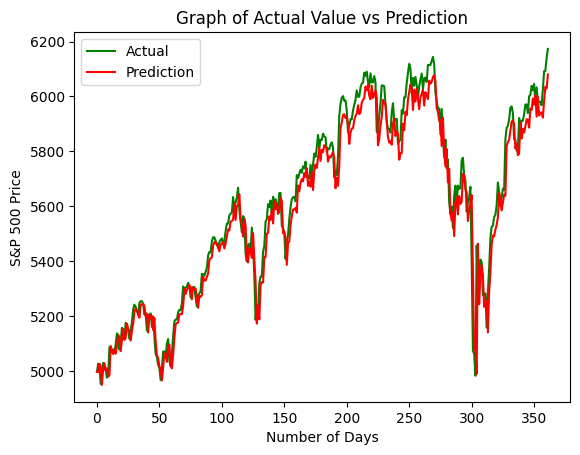

In [55]:
plt.plot(gru_actual_lst, label="Actual", color='green')
plt.plot(gru_pred_lst, label="Prediction", color='red')

plt.title("Graph of Actual Value vs Prediction")
plt.xlabel("Number of Days")
plt.ylabel("S&P 500 Price")

plt.legend()
plt.show()

#### Model Evaluation Metrics (Original Values)

In [56]:
rmse = root_mean_squared_error(y_true=gru_actual_lst,
                               y_pred=gru_pred_lst)

r2 = r2_score(y_true=gru_actual_lst,
              y_pred=gru_pred_lst)

In [57]:
print(f"RMSE: {rmse:.5f}")
print(f"R2  : {r2:.5f}")

RMSE: 69.64294
R2  : 0.95757


## 8. Save Error of Prediction

In [60]:
gru_error_dict_lst = []

gru_error_lst = gru_error_lst.tolist()

for i in range(0, len(gru_error_lst)):
    
    temp = gru_error_lst[i]
    
    gru_error_dict_lst.append(temp[0])

In [61]:
gru_error_dic = {
    'GRU Error': gru_error_dict_lst
}

In [ ]:
gru_error_pd = pd.DataFrame(gru_error_dic)

folder_name = 'processed_data'

gru_error_filename = "gru_error.csv"

datafolder_filepath = os.path.join(os.getcwd(), folder_name)

if os.path.isdir(datafolder_filepath) == False:
    os.mkdir(datafolder_filepath)
    print(f"Folder {folder_name} created.")

gru_error_filepath = os.path.join(os.getcwd(), folder_name, gru_error_filename)

gru_error_pd.to_csv(gru_error_filepath, index=False)

print(f"GRU prediction error file successfully saved at:\n{gru_error_filepath}\n")

GRU prediction error file successfully saved at:
c:\Users\ADMIN\OneDrive\SHARED FILES\D3 Sem1\Advanced Machine Learning\Project\data\gru_error.csv

